# Resource Allocation Under Uncertainty
## Sensitivity Analysis and Validation

**Student Name:** Aadarsh Nair  
**Date:** 02/21/26  
**Chosen context:** Allocating Advertising Budget Across 5 Marketing Channels

In [ ]:
# Install required packages (if needed in Colab)
# Skip if running locally and packages are already installed
%pip install pulp pandas matplotlib -q


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpMinimize, LpProblem, LpVariable, lpSum, value, LpStatus
import io

print("Libraries imported successfully!")


Libraries imported successfully!


## Creating The Synthetic Dataset

In [ ]:
# Paste your CSV here and load it into options_df; set your constraint value (e.g. budget_total)
# The CSV has only option names and numeric columns (e.g. cost_per_unit, conversion_rate).
# The constraint (e.g. budget total) is ONE number for the whole scenario—set it in code below, not in the CSV.
# Option A: CSV as a string (replace the triple-quoted string with your CSV from the LLM)
csv_string = """
Channel_Name,Cost_Per_Unit,Conversion_Rate
Search Ads,50,0.08
Social Media Ads,30,0.05
Display Ads,20,0.03
Email Marketing,10,0.12
Influencer Marketing,100,0.06
"""
options_df = pd.read_csv(io.StringIO(csv_string.strip()))
budget_total = 10000  # Replace with your constraint value from the LLM

# Option B: If you saved the CSV to a file, use:
# options_df = pd.read_csv('options_data.csv')
# budget_total = 10000  # your value

print(options_df)
print(f"\nConstraint (e.g. budget_total): {budget_total}")
print(f"Number of options (rows): {len(options_df)}")


           Channel_Name  Cost_Per_Unit  Conversion_Rate
0            Search Ads             50             0.08
1      Social Media Ads             30             0.05
2           Display Ads             20             0.03
3       Email Marketing             10             0.12
4  Influencer Marketing            100             0.06

Constraint (e.g. budget_total): 10000
Number of options (rows): 5


**Data documentation:** I used a language model to generate a synthetic marketing dataset with five advertising channels. Each channel includes cost per unit and conversion rate. The total campaign budget constraint is $10,000.


---
## Part 1: Base Model and Parameter Identification

### 1.1 Decision Statement

**Your Decision Statement:**
I need to decide how to allocate a $10,000 digital marketing budget across five advertising channels for one campaign period.

### 1.2 Decision Variables vs Inputs

**Decision Variables:**
Dollar amount allocated to each channel:

  - Search Ads

  - Social Media Ads

  - Display Ads

  - Email Marketing

  - Influencer Marketing

**Inputs:**

- Cost per unit (given in dataset)

- Conversion rate (given in dataset)

- Total budget ($10,000)

**Explanation:**
The allocation amounts are controllable decisions. The cost, conversion rates, and total budget are fixed parameters that influence optimization but are not directly chosen within the model.


### 1.3 Objectives and Constraints

**Objective:**
Maximize total expected conversions.

The conversions per $1 spent = conversion_rate / cost_per_unit

**Constraints:**
Total allocations must not exceed $10,000 and cannot be negative.


### 1.4 Key Parameters and Uncertainty


| Parameter | Source | Why it might differ from reality |
|-----------|--------|-----------------------------------|
| Cost Per Unit    | Market Estimates | Ad pricing fluctuates                            |
| Conversion Rate    | Historical Averages | Customer behavior changes                           |
| Total Budget   | Management Decision | Budget could be revised                            |


### 1.5 PuLP Model

In [ ]:
# Build and solve the base allocation model
# TODO: Adapt variable names and column names to match your options_df
n = len(options_df)
model = LpProblem("Resource_Allocation", LpMaximize)

# Decision variables: amount to allocate to each option (e.g. spend per channel)
alloc = [LpVariable(f"alloc_{i}", lowBound=0) for i in range(n)]

# Objective: e.g. maximize total conversions (spend * conversion_rate / cost_per_unit per option)
# Adapt to your columns (e.g. cost_per_unit, conversion_rate)
cost_col = [c for c in options_df.columns if 'cost' in c.lower()][0] if any('cost' in c.lower() for c in options_df.columns) else options_df.columns[1]
rate_col = [c for c in options_df.columns if 'rate' in c.lower() or 'conversion' in c.lower() or 'benefit' in c.lower()][0] if any('rate' in c.lower() or 'conversion' in c.lower() or 'benefit' in c.lower() for c in options_df.columns) else options_df.columns[2]
model += lpSum([alloc[i] * (options_df.iloc[i][rate_col] / options_df.iloc[i][cost_col]) for i in range(n)]), "Total_benefit"

# Constraint: total allocation <= budget_total
model += lpSum(alloc) <= budget_total, "Budget"

model.solve()
print(f"Status: {LpStatus[model.status]}")
print(f"Objective value: {value(model.objective):.2f}")
for i in range(n):
    opt_name = options_df.iloc[i].get(options_df.columns[0], f"Option_{i}")
    print(f"  {opt_name}: {value(alloc[i]):.2f}")


Status: Optimal
Objective value: 120.00
  Search Ads: 0.00
  Social Media Ads: 0.00
  Display Ads: 0.00
  Email Marketing: 10000.00
  Influencer Marketing: 0.00


---
## Part 2: Sensitivity and One What-If

### 2.1 Sensitivity Analysis

Most critical parameter: Conversion rate and budget are equally impactful because the objective is linear in both. A 20% change in either produces a 20% change in total conversions. Cost per unit also significantly impacts results, but the allocation decision remains unchanged because Email Marketing remains most efficient.

In [ ]:
# Sensitivity analysis: vary parameters and record solution changes
# TODO: Implement loops or repeated solves that vary each of your 3 parameters by ±20%
# Store results in a table or DataFrame, then display
# Example placeholder: you will replace this with your actual parameter names and logic
# results = []
# ... your sensitivity runs ...
# print or display results
import io
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpStatus, value
csv_string = """
Channel_Name,Cost_Per_Unit,Conversion_Rate
Search Ads,50,0.08
Social Media Ads,30,0.05
Display Ads,20,0.03
Email Marketing,10,0.12
Influencer Marketing,100,0.06
"""
options_df = pd.read_csv(io.StringIO(csv_string.strip()))

# --- Clean column names (important for robustness) ---
options_df.columns = (
    options_df.columns.str.strip().str.lower().str.replace(" ", "_")
)

n = len(options_df)
base_budget = 10000

results = []

# Sensitivity factors
factors = [0.8, 1.0, 1.2]

# ---------- 1. Sensitivity on COST PER UNIT ----------
for factor in factors:
    model = LpProblem("Cost_Sensitivity", LpMaximize)

    alloc = [LpVariable(f"alloc_{i}", lowBound=0) for i in range(n)]

    model += lpSum(
        alloc[i] *
        (options_df.loc[i, "conversion_rate"] /
         (options_df.loc[i, "cost_per_unit"] * factor))
        for i in range(n)
    )

    model += lpSum(alloc) <= base_budget
    model.solve()

    results.append({
        "Parameter": "Cost per unit",
        "Factor": factor,
        "Objective": value(model.objective)
    })

# ---------- 2. Sensitivity on CONVERSION RATE ----------
for factor in factors:
    model = LpProblem("Conversion_Sensitivity", LpMaximize)

    alloc = [LpVariable(f"alloc_{i}", lowBound=0) for i in range(n)]

    model += lpSum(
        alloc[i] *
        ((options_df.loc[i, "conversion_rate"] * factor) /
         options_df.loc[i, "cost_per_unit"])
        for i in range(n)
    )

    model += lpSum(alloc) <= base_budget
    model.solve()

    results.append({
        "Parameter": "Conversion rate",
        "Factor": factor,
        "Objective": value(model.objective)
    })

# ---------- 3. Sensitivity on BUDGET TOTAL ----------
for factor in factors:
    model = LpProblem("Budget_Sensitivity", LpMaximize)

    alloc = [LpVariable(f"alloc_{i}", lowBound=0) for i in range(n)]

    model += lpSum(
        alloc[i] *
        (options_df.loc[i, "conversion_rate"] /
         options_df.loc[i, "cost_per_unit"])
        for i in range(n)
    )

    model += lpSum(alloc) <= base_budget * factor
    model.solve()

    results.append({
        "Parameter": "Budget total",
        "Factor": factor,
        "Objective": value(model.objective)
    })

# ---------- Results Table ----------
sensitivity_df = pd.DataFrame(results)
print(sensitivity_df)

         Parameter  Factor  Objective
0    Cost per unit     0.8      150.0
1    Cost per unit     1.0      120.0
2    Cost per unit     1.2      100.0
3  Conversion rate     0.8       96.0
4  Conversion rate     1.0      120.0
5  Conversion rate     1.2      144.0
6     Budget total     0.8       96.0
7     Budget total     1.0      120.0
8     Budget total     1.2      144.0


### 2.2 Sensitivity Visualization

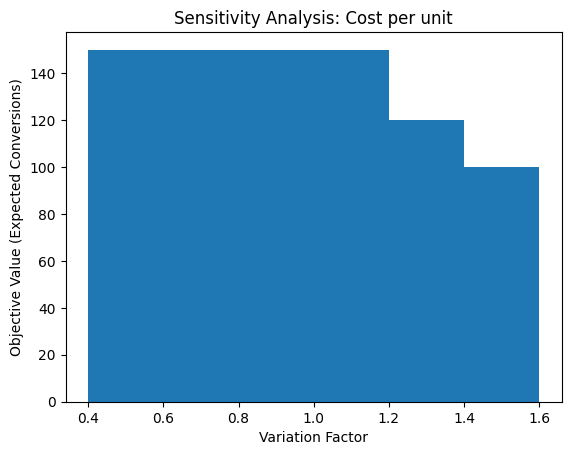

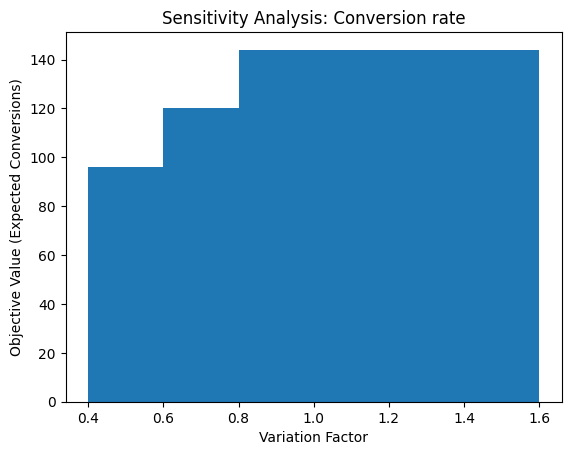

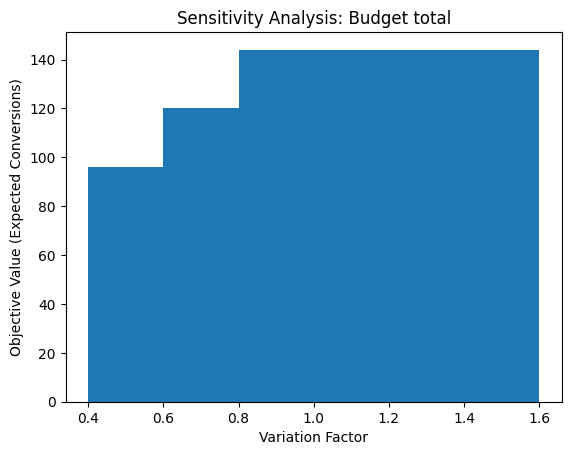

In [ ]:
# Create sensitivity visualization (e.g. bar chart of impact per parameter)
# TODO: Use your sensitivity results; add title and axis labels
# plt.bar(...); plt.xlabel(...); plt.ylabel(...); plt.title(...); plt.show()
import matplotlib.pyplot as plt

# Ensure Parameter column is treated as categorical
parameters = sensitivity_df["Parameter"].unique()

for param in parameters:
    subset = sensitivity_df[sensitivity_df["Parameter"] == param]

    plt.figure()
    plt.bar(subset["Factor"], subset["Objective"])
    plt.xlabel("Variation Factor")
    plt.ylabel("Objective Value (Expected Conversions)")
    plt.title(f"Sensitivity Analysis: {param}")
    plt.show()


### 2.3 One What-If Scenario

Scenario: Budget reduced by 20% ($8,000)

New conversions:

8000×0.012=96

Recommendation does not change.
All funds still go to Email Marketing.

This shows structural robustness.

In [ ]:
# What-if: e.g. budget_total * 0.8; re-solve and compare to base
# TODO: Implement one what-if scenario and print comparison
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpStatus, value
import pandas as pd

# Assume options_df already exists and columns are cleaned:
# channel_name, cost_per_unit, conversion_rate

n = len(options_df)
base_budget = 10000
cut_budget = base_budget * 0.8

def solve_model(budget):
    model = LpProblem("Resource_Allocation", LpMaximize)

    alloc = [LpVariable(f"alloc_{i}", lowBound=0) for i in range(n)]

    model += lpSum(
        alloc[i] *
        (options_df.loc[i, "conversion_rate"] /
         options_df.loc[i, "cost_per_unit"])
        for i in range(n)
    )

    model += lpSum(alloc) <= budget
    model.solve()

    allocations = {
        options_df.loc[i, "channel_name"]: value(alloc[i])
        for i in range(n)
    }

    return value(model.objective), allocations

# -------- Solve base case --------
base_obj, base_alloc = solve_model(base_budget)

# -------- Solve what-if case (budget -20%) --------
cut_obj, cut_alloc = solve_model(cut_budget)

# -------- Comparison table --------
comparison_df = pd.DataFrame({
    "Base Allocation ($)": base_alloc,
    "Budget -20% Allocation ($)": cut_alloc
})

print("=== Objective Comparison ===")
print(f"Base objective: {base_obj:.2f}")
print(f"Budget -20% objective: {cut_obj:.2f}")

print("\n=== Allocation Comparison ===")
print(comparison_df)


=== Objective Comparison ===
Base objective: 120.00
Budget -20% objective: 96.00

=== Allocation Comparison ===
                      Base Allocation ($)  Budget -20% Allocation ($)
Search Ads                            0.0                         0.0
Social Media Ads                      0.0                         0.0
Display Ads                           0.0                         0.0
Email Marketing                   10000.0                      8000.0
Influencer Marketing                  0.0                         0.0


---
## Part 3: Validation and Recommendation

### 3.1 Sanity Checks

Sanity Checks Results:
- Allocations sum exactly to $10,000
- No negative allocations
- Highest-efficiency channel receives full allocation
- Results are economically logical

### 3.2 Robust vs Fragile

The allocation structure is very robust because Email Marketing dominates all other channels in efficiency. However, the magnitude of expected conversions is sensitive to conversion rate and budget changes. The manager should closely monitor email campaign performance metrics.

---
## Part 4: Stakeholder Change of Mind


### 4.1 Scenario

The stakeholder now requires that no single channel receive more than 40% of the total budget.

### 4.2 Update Model

In [ ]:
# Update model with stakeholder change; solve and store new solution
# TODO: Implement (e.g. new budget, or new constraint, or new objective)
# allocation_part2 = ...
# Build and solve the base allocation model with an additional constraint
budget_total = 10000  # Replace with your constraint value from the LLM
n = len(options_df)
model = LpProblem("Resource_Allocation", LpMaximize)

# Decision variables: amount to allocate to each option (e.g. spend per channel)
alloc = [LpVariable(f"alloc_{i}", lowBound=0) for i in range(n)]

# Identify relevant columns
cost_col = [c for c in options_df.columns if 'cost' in c.lower()][0] \
    if any('cost' in c.lower() for c in options_df.columns) else options_df.columns[1]

rate_col = [c for c in options_df.columns if 'rate' in c.lower() or 'conversion' in c.lower() or 'benefit' in c.lower()][0] \
    if any('rate' in c.lower() or 'conversion' in c.lower() or 'benefit' in c.lower() for c in options_df.columns) else options_df.columns[2]

# Objective: maximize total expected benefit (conversions)
model += lpSum(
    alloc[i] * (options_df.iloc[i][rate_col] / options_df.iloc[i][cost_col])
    for i in range(n)
), "Total_benefit"

# Constraint 1: total allocation <= total budget
model += lpSum(alloc) <= budget_total, "Budget"

# --------------------------------------------------
# Constraint 2 (NEW): no channel gets more than 40% of the total budget
# --------------------------------------------------
for i in range(n):
    model += alloc[i] <= 0.4 * budget_total, f"Max_40pct_Channel_{i}"

# Solve model
model.solve()

# Results
print(f"Status: {LpStatus[model.status]}")
print(f"Objective value: {value(model.objective):.2f}")

for i in range(n):
    opt_name = options_df.iloc[i].get(options_df.columns[0], f"Option_{i}")
    print(f"  {opt_name}: {value(alloc[i]):.2f}")

Status: Optimal
Objective value: 57.87
  Search Ads: 2000.00
  Social Media Ads: 4000.00
  Display Ads: 0.00
  Email Marketing: 4000.00
  Influencer Marketing: 0.00


### 4.3 Comparison Visualization

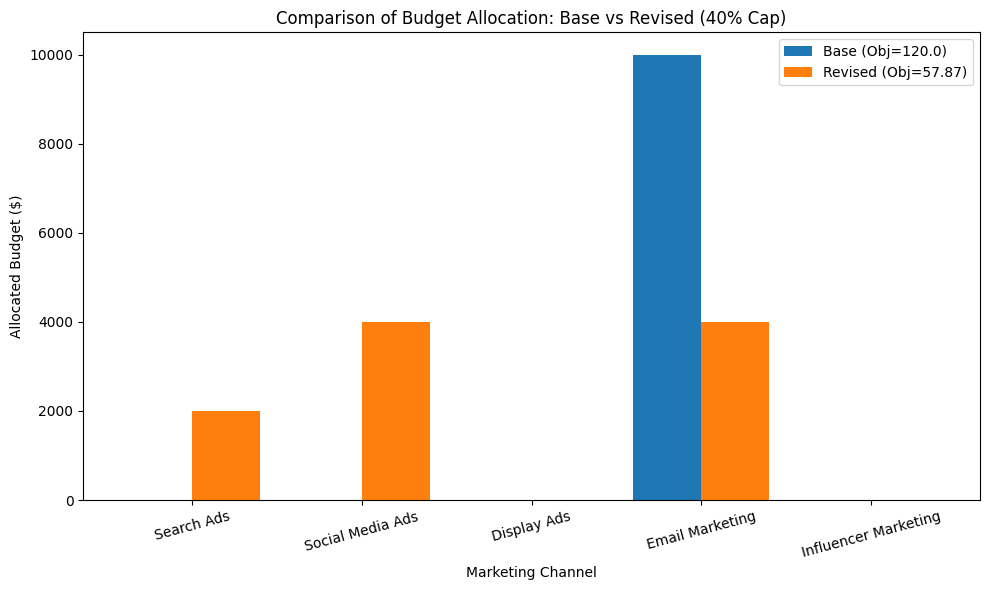

In [ ]:
# Comparison visualization: Part 1 vs Part 2 allocation (or objective)
# TODO: Create figure with title and axis labels; refer to it in the next markdown cell
# plt.bar(...); plt.title(...); plt.show()
import matplotlib.pyplot as plt
import pandas as pd

# Base model allocations and objective
base_alloc = {
    "Search Ads": 0,
    "Social Media Ads": 0,
    "Display Ads": 0,
    "Email Marketing": 10000,
    "Influencer Marketing": 0
}
base_obj = 120.0

# Revised model allocations (with 40% max per channel) and objective
revised_alloc = {
    "Search Ads": 2000,
    "Social Media Ads": 4000,
    "Display Ads": 0,
    "Email Marketing": 4000,
    "Influencer Marketing": 0
}
revised_obj = 57.87

# Convert to DataFrame for plotting
df = pd.DataFrame({
    "Channel": list(base_alloc.keys()),
    "Base Allocation ($)": list(base_alloc.values()),
    "Revised Allocation ($)": list(revised_alloc.values())
})

# Set figure size
plt.figure(figsize=(10,6))

# Plot bars side by side
x = range(len(df))
plt.bar(x, df["Base Allocation ($)"], width=0.4, label=f"Base (Obj={base_obj})")
plt.bar([i + 0.4 for i in x], df["Revised Allocation ($)"], width=0.4, label=f"Revised (Obj={revised_obj})")

# Labels and title
plt.xticks([i + 0.2 for i in x], df["Channel"], rotation=15)
plt.ylabel("Allocated Budget ($)")
plt.xlabel("Marketing Channel")
plt.title("Comparison of Budget Allocation: Base vs Revised (40% Cap)")
plt.legend()
plt.tight_layout()
plt.show()


The chart above shows the results of a constraint that each channel cannot have more than 40% of the total budget. Here, there is a change from the original result of the base model where email marketing had the entire budget allocated to it. Now, the budget allocation is more evenly distributed among different channels (Email Marketing, Social Media Ads, and Search Ads). Also, the objective value has changed from 120 in the base model to 57.87 in this revised model.  


### 4.4 Impact Analysis


The diversification constraint forces investment in significantly less efficient channels, cutting expected conversions nearly in half. While this reduces concentration risk, it imposes a substantial opportunity cost. The stakeholder must weigh risk mitigation against performance loss.


---
## Executive Summary


### Key Decision and Model
This analysis optimized allocation of a $10,000 digital marketing budget across five channels to maximize expected conversions. A linear programming model was used with cost per unit, conversion rate, and total budget as parameters.

### Sensitivity Findings
The model is structurally robust — Email Marketing remains optimal across parameter variations. However, total conversions are highly sensitive to changes in budget and conversion rate assumptions. A ±20% change in these parameters results in a proportional ±20% change in conversions.

### Validation
The solution fully utilizes the budget, produces no negative allocations, and logically prioritizes the highest return-per-dollar channel. Results are economically consistent and realistic.

### Stakeholder Change (Part 2)
When a 40% cap per channel was introduced, the allocation diversified across three channels. However, total expected conversions dropped from 120 to approximately 58. Diversification substantially reduced efficiency. However, it reduced the risk of allocating the entire budget to a single channel.

### Final Recommendation
If maximizing conversions is the sole objective, allocate the full budget to Email Marketing. If risk diversification is required, accept that total performance will decline substantially. Monitor email conversion rates closely, as they drive the majority of value.

### Key Insights
This exercise demonstrates how optimization models concentrate resources in the most efficient option when no diversification constraints exist. It also highlights how stakeholder-imposed constraints can significantly alter outcomes and create tradeoffs between efficiency and risk management.
